In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import tensorflow as tf
import pickle
%matplotlib inline

# Methods

## Newton-Raphson

In [6]:
def cons(x):
    return tf.constant(x, dtype=tf.float32)

In [7]:
def compute_hessian(fn, vars):
    mat = []
    for v1 in vars:
        temp = []
        for v2 in vars:
            temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
        temp = [cons(0) if t == None else t for t in temp]
        temp = tf.stack(temp)
        mat.append(temp)
    mat = tf.stack(mat)
    return mat

In [8]:
def compute_grads(fn, vars):
    grads = []
    for v in vars:
        grads.append(tf.gradients(fn, v)[0])
    return tf.reshape(tf.stack(grads), shape=[len(vars), -1])

In [9]:
def optimize(all_variables, update):
    optmize_variables = []
    for i in range(len(all_variables)):
        optmize_variables.append(all_variables[i].assign(all_variables[i] - tf.squeeze(update[i])))
    return tf.stack(optmize_variables)

In [10]:
def NewtonRaphson(x, f, num_iterations):
    hessian = compute_hessian(f, x)
    hessian_inv = tf.matrix_inverse(hessian)
    g = compute_grads(f, x)
    update = tf.unstack(tf.matmul(hessian_inv, g))
    optimize_op = optimize(x, update)

    sess = tf.Session()
    sess.run(tf.initialize_all_variables())

    func = np.inf
    history_loss = []
    for i in range(num_iterations):
        prev = func
        v, func = sess.run([x, f])
        history_loss.append(func)
        #print( v, func )
        sess.run(optimize_op)
    sess.close()
    return v, history_loss

### Test

In [11]:
x = []
for i in range( 2 ):
    x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
print(x)

f = tf.pow(x, 4) + 5

print(NewtonRaphson(x,f,10))

[<tf.Variable 'Variable:0' shape=() dtype=float32_ref>, <tf.Variable 'Variable_1:0' shape=() dtype=float32_ref>]
Instructions for updating:
Use `tf.global_variables_initializer` instead.
([0.012586759, 0.02300002], [array([5.05482 , 5.611221], dtype=float32), array([5.0108285, 5.120735 ], dtype=float32), array([5.002139, 5.023849], dtype=float32), array([5.0004225, 5.0047107], dtype=float32), array([5.0000834, 5.0009303], dtype=float32), array([5.0000167, 5.0001836], dtype=float32), array([5.0000033, 5.0000362], dtype=float32), array([5.0000005, 5.000007 ], dtype=float32), array([5.       , 5.0000014], dtype=float32), array([5.       , 5.0000005], dtype=float32)])


In [12]:
tf.reset_default_graph()

## Gradient Descent

In [13]:
def GradientDescent(X, f, num_iterations=100, lr=0.1):
    sess = tf.Session()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(f)
    sess.run(tf.initialize_all_variables())
    X_opt = None
    history_loss = []
    for i in range(num_iterations):
        X_opt, _, cost = sess.run([X, optimizer, f])
        history_loss.append(cost)
    sess.close()
    return X_opt, history_loss

### Test

In [14]:
x = tf.get_variable("x", initializer=np.random.random(2) * 10.24 - 5.12)

f2 = tf.pow(x, 2) + 5

print(GradientDescent(x, f2, 10, 0.1))

(array([-0.11751653, -0.1498976 ]), [array([6.19783837, 6.94890047]), array([5.76661655, 6.24729629]), array([5.49063459, 5.79826962]), array([5.31400613, 5.51089255]), array([5.20096392, 5.32697123]), array([5.12861691, 5.20926159]), array([5.08231482, 5.13392741]), array([5.05268149, 5.08571354]), array([5.03371615, 5.05485667]), array([5.02157834, 5.03510827])])


In [15]:
tf.reset_default_graph()

## Gradient Descent With Momentum

In [16]:
def GradientDescentWithMomentum(X, f, num_iterations=100, lr=0.1, betha=0.4):
    sess = tf.Session()
    optimizer = tf.train.MomentumOptimizer(learning_rate=lr, momentum=betha).minimize(f)
    sess.run(tf.initialize_all_variables())
    X_opt = None
    history_loss = []
    for i in range(num_iterations):
        X_opt, _, cost = sess.run([X, optimizer, f])
        history_loss.append(cost)
        #print(X_opt, cost)
    sess.close()
    return X_opt, history_loss

### Test

In [17]:
X1 = tf.get_variable("X1", initializer=np.random.random(2) * 10.24 - 5.12)

f3 = tf.pow(X1, 2) + 5

print(GradientDescentWithMomentum(X1, f3, 10, 0.1, 0.4))

(array([-0.04558446, -0.01682886]), [array([22.21338963,  7.34607805]), array([16.01656928,  6.50148994]), array([10.39811885,  5.73573006]), array([7.1328077 , 5.29068844]), array([5.677563  , 5.09234763]), array([5.16289712, 5.02220187]), array([5.0240465 , 5.00327739]), array([5.00060719, 5.00008276]), array([5.00105355, 5.00014359]), array([5.00238208, 5.00032466])])


In [18]:
tf.reset_default_graph()

## Hill Climbing

In [19]:
alpha = 2.0

def powerLawGenerator(x):
    dir = np.random.choice([-1,1])
    return dir * (1.0 - x)**(1 - alpha)

In [20]:
def checkConstraint(x, limits):
    x_min, x_max = limits
    for dim in x:
        if dim < x_min or dim > x_max:
            return False
    return True

In [21]:
def HillClimbingStep(x, f, limits, delta, powerLaw):
    n = len(x)
    y = np.array(x)
    fx = f(x)
    if not powerLaw:
        y += delta * np.random.randn(n)
    else:
        y += delta * powerLawGenerator(np.random.randn(n))
    if not checkConstraint(y, limits):
        return x
    fx_prime = f(y)
    return (y if fx_prime <= fx else x)

In [22]:
def HillClimbing(x, f, limits, num_iterations=100, delta=0.6, powerLaw=True):
    history_loss = []
    for i in range(num_iterations):
        x_next = HillClimbingStep(x, f, limits, delta, powerLaw)
        x = x_next
        history_loss.append(f(x))
        #print(x, f(x))
    return x, history_loss

### Test

In [23]:
X = np.random.random(2) * 10.24 - 5.12

f4 = lambda x: np.sum(x**2) + 5

print(HillClimbing(X, f4, (-5, 5)))

(array([ 0.25919413, -0.15635558]), [18.153167381257155, 17.069507790869316, 17.069507790869316, 17.069507790869316, 17.069507790869316, 13.613551870142318, 13.613551870142318, 8.759233050407252, 8.759233050407252, 8.759233050407252, 6.562524285392628, 5.131497928151589, 5.131497928151589, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.101692314919257, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.091628668032552, 5.0916

## Simulated Annealing

In [24]:
def SimulatedAnnealing(x, f, limits, t_max=1000, delta=0.6, powerLaw=True):
    history_loss = []
    for t in range(1, t_max + 1):
        T = t / t_max
        x_next = np.array(x)
        if not powerLaw:
            x_next += delta * np.random.randn(len(x))
        else:
            x_next += delta * powerLawGenerator(np.random.randn(len(x)))
        DE = f(x_next) - f(x)
        q = min(1,np.exp(-DE/T))
        if checkConstraint(x_next, limits) and DE < 0:
            x = x_next
        elif checkConstraint(x_next, limits) and T != 0 and np.random.random() < q:
            x = x_next
        #print(x, f(x))
        history_loss.append(f(x))
    return x, history_loss

### Test

In [25]:
X = np.random.random(2) * 10.24 - 5.12

f4 = lambda x: np.sum(x**2) + 5

print(SimulatedAnnealing(X, f4, (-5.0, 5.0), t_max=100, delta=1, powerLaw=False))

(array([0.25650237, 0.37878949]), [36.81550257004427, 32.15189885844809, 26.95010813961982, 21.220111765696174, 21.220111765696174, 20.474417636741144, 14.569070722469382, 14.569070722469382, 14.569070722469382, 11.506143831546403, 7.185620240409573, 6.9217794523103535, 5.444865095175578, 5.444865095175578, 5.497109080810722, 5.539454395420861, 5.539454395420861, 5.539454395420861, 5.539454395420861, 5.539454395420861, 5.539454395420861, 5.539454395420861, 5.539454395420861, 5.539454395420861, 5.532387666365361, 5.532387666365361, 5.532387666365361, 5.532387666365361, 5.532387666365361, 5.532387666365361, 5.532387666365361, 5.206188841378068, 5.206188841378068, 5.206188841378068, 5.206188841378068, 5.206188841378068, 5.206188841378068, 5.1916817372507635, 5.1916817372507635, 5.1916817372507635, 5.1916817372507635, 5.1916817372507635, 5.1916817372507635, 5.131661184419736, 5.131661184419736, 5.131661184419736, 5.131661184419736, 5.131661184419736, 5.131661184419736, 5.131661184419736, 5

# Global Variables

In [26]:
num_experiments = 30

In [27]:
def standarDeviation(x):
    return np.sqrt(np.sum((x-np.median(x))**2)/len(x))

In [28]:
def getErrorPlot(data, num_steps=100):
    x = list(range(0, data.shape[1], num_steps))
    y = np.empty(0)
    std = np.empty(0)
    for j in range(0, data.shape[1], num_steps):
        xj = data[:, j]
        y = np.append(y, np.median(xj))
        std = np.append(std, standarDeviation(xj))
    return x, y, std

In [29]:
def plotGraphs(graph):
    plt.plot(list(range(1,1001)), np.average(graph, axis=0), label='Average')
    plt.plot(list(range(1,1001)), np.median(graph, axis=0), label='Median')
    plt.plot(list(range(1,1001)), np.min(graph, axis=0), label='Min')
    plt.plot(list(range(1,1001)), np.max(graph, axis=0), label='Max')
    x, y, z = getErrorPlot(graph)
    plt.errorbar(x, y, z, marker='^', ls='None')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('iterations')
    plt.ylabel('f(x)')

In [78]:
def plotGraphs10D(graph):
    plt.plot(list(range(1,10001)), np.average(graph, axis=0), label='Average')
    plt.plot(list(range(1,10001)), np.median(graph, axis=0), label='Median')
    plt.plot(list(range(1,10001)), np.min(graph, axis=0), label='Min')
    plt.plot(list(range(1,10001)), np.max(graph, axis=0), label='Max')
    x, y, z = getErrorPlot(graph, num_steps=10000)
    plt.errorbar(x, y, z, marker='^', ls='None')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('iterations')
    plt.ylabel('f(x)')

# Rastrigin
On an n-dimensional domain it is defined by:
$$f(x) = Ad + \sum_{i=1}^{d}x_i-Acos(2\pi x_i)$$

In [30]:
def Rastrigin(x):
    A = 10
    d = len(x)
    return A * d + np.sum(x**2 - A * np.cos(2*np.pi*x))

def RastriginTF(x):
    A = 10
    d = len(x)
    return A * d + tf.reduce_sum(tf.pow(x, 2) - A * tf.cos([2 * np.pi * xi for xi in x]))

## Plotting

In [31]:
def RastriginPlot(x, y):
    return 20 + (x**2 - 10 * np.cos(2*np.pi*x)) + (y**2 - 10 * np.cos(2*np.pi*y))

x = np.linspace(-5.12, 5.12, 400)
y = np.linspace(-5.12, 5.12, 400)
X, Y = np.meshgrid(x, y)
Z = RastriginPlot(X,Y)

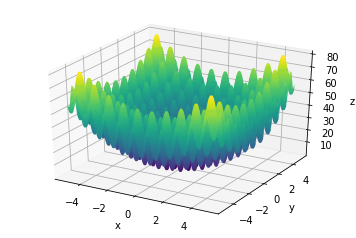

In [32]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Rastrigin with Newton-Raphson

### 2-Dimensions  

In [69]:
sess = tf.Session()
optimal_found1 = []

total_history = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 1000)
    #total_history += np.array(history_loss)
    total_history.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found1.append(optimum)
    
total_history = np.array(total_history)
print(total_history.shape)
sess.close()

(30, 1000)


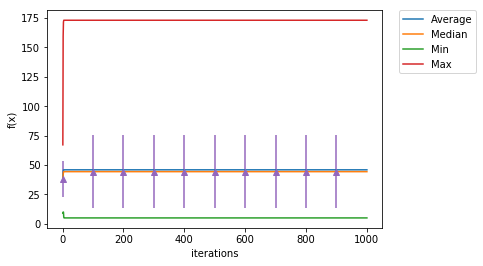

In [70]:
plotGraphs(total_history)

In [71]:
print("Optimal founds:")
for x in optimal_found1:
    print(Rastrigin(np.array(x)))

Optimal founds:
64.6248779296875
27.27680015563965
44.3331184387207
48.54330062866211
173.1826171875
58.59428405761719
28.85355281829834
72.66572570800781
44.3331184387207
20.251272201538086
24.873842239379883
4.974790573120117
56.27252960205078
58.59428024291992
44.3331184387207
28.853553771972656
62.61474609375
9.94955825805664
27.27680015563965
15.919242858886719
26.281841278076172
40.50254440307617
16.914201736450195
54.57389831542969
66.63512802124023
64.6248779296875
7.959662437438965
66.63512802124023
56.27252960205078
60.60456085205078


In [72]:
tf.reset_default_graph()

### 10-Dimensions

In [74]:
sess = tf.Session()
optimal_found21 = []

total_history21 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 10000)
    #total_history += np.array(history_loss)
    total_history21.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found21.append(optimum)
    
total_history21 = np.array(total_history21)
print(total_history21.shape)
sess.close()

(30, 10000)


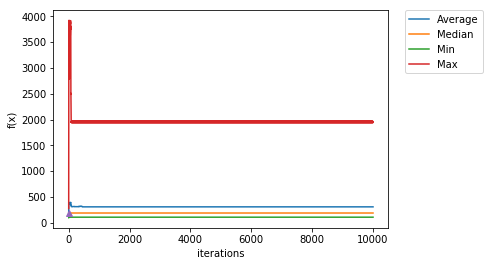

In [79]:
plotGraphs10D(total_history21)

In [80]:
print("Optimal founds:")
for x in optimal_found21:
    print(Rastrigin(np.array(x)))

Optimal founds:
199.64142608642578
146.9358139038086
114.99582195281982
243.68328857421875
142.91526412963867
229.56434631347656
141.62904739379883
140.13976287841797
146.5834197998047
218.70804595947266
107.59786415100098
1299.33837890625
170.62559509277344
263.1091766357422
723.8820190429688
200.6363754272461
278.7104034423828
346.8373718261719
172.51319885253906
138.35369110107422
164.6620864868164
1953.252197265625
177.33938598632812
226.3244400024414
265.557861328125
149.23715209960938
153.13595962524414
170.91597747802734
318.2976989746094
225.27981567382812


In [81]:
tf.reset_default_graph()

## Rastrigin with Gradient Descent

### 2-Dimensions

In [87]:
sess = tf.Session()
optimal_found2 = []

total_history2 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = GradientDescent(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history2.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found2.append(optimum)
    
total_history2 = np.array(total_history2)
print(total_history2.shape)
sess.close()

(30, 1000)


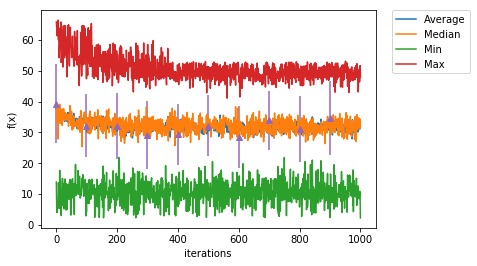

In [88]:
plotGraphs(total_history2)

In [89]:
print("Optimal founds:")
for x in optimal_found2:
    print(Rastrigin(np.array(x)))

Optimal founds:
43.87887763977051
40.17009162902832
4.395713806152344
39.79482841491699
32.74654483795166
27.626662731170654
44.834678649902344
25.733779907226562
29.194660186767578
48.36265754699707
26.43130874633789
27.35896873474121
35.586710929870605
35.529022216796875
39.29043006896973
20.33817768096924
29.096915245056152
19.37247347831726
27.11729621887207
14.275048732757568
28.744909286499023
34.495633125305176
35.8014612197876
44.10295867919922
40.21110725402832
14.019403457641602
23.46574854850769
29.137435913085938
32.45532035827637
26.03416681289673


### 10-Dimensions

In [ ]:
sess = tf.Session()
optimal_found22 = []

total_history22 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = GradientDescent(x, f1, 10000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history22.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found22.append(optimum)
    
total_history22 = np.array(total_history22)
print(total_history22.shape)
sess.close()

In [ ]:
plotGraphs(total_history22)

In [ ]:
print("Optimal founds:")
for x in optimal_found22:
    print(Rastrigin(np.array(x)))

In [86]:
tf.reset_default_graph()

## Rastrigin with Momentum

### 2-Dimensions

In [73]:
sess = tf.Session()
optimal_found3 = []

total_history3 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history3.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found3.append(optimum)
    
total_history3 = np.array(total_history3)
print(total_history3.shape)
sess.close()

(30, 1000)


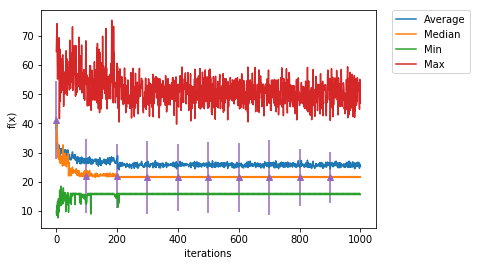

In [90]:
plotGraphs(total_history3)

In [94]:
print("Optimal founds:")
for x in optimal_found3:
    print(Rastrigin(np.array(x)))

Optimal founds:
16.054221391677856
45.58212471008301
41.51041793823242
21.124197840690613
16.054223775863647
19.249613285064697
35.52626132965088
24.146577835083008
16.282244205474854
16.282246589660645
21.869359254837036
53.53273391723633
21.109208583831787
48.96734046936035
24.304597854614258
16.282244205474854
23.614449977874756
21.64133644104004
18.84697914123535
18.15683114528656
38.345319747924805
22.27199101448059
17.928808212280273
43.470726013183594
34.48457145690918
24.146577835083008
18.15683114528656
21.337231397628784
18.618956327438354
19.249610900878906


### 10-Dimensions

In [ ]:
sess = tf.Session()
optimal_found23 = []

total_history23 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())
    
    f1 = RastriginTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 10000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history23.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found23.append(optimum)
    
total_history23 = np.array(total_history23)
print(total_history23.shape)
sess.close()

In [ ]:
plotGraphs(total_history23)

In [ ]:
print("Optimal founds:")
for x in optimal_found23:
    print(Rastrigin(np.array(x)))

## Rastrigin with Hill-Climbing

### 2-Dimensions

In [77]:
optimal_found4 = []
total_history4 = []

for i in range(num_experiments):
    x = np.random.random(2) * 10.24 - 5.12
    f = Rastrigin
    optimum, history_loss = HillClimbing(x, f, (-5.12,5.12), num_iterations=1000)
    #total_history += np.array(history_loss)
    total_history4.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found4.append(optimum)

total_history4 = np.array(total_history4)
print(total_history4.shape)

(30, 1000)


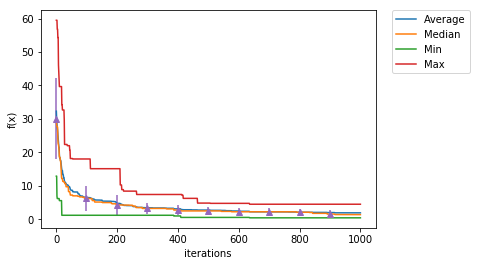

In [95]:
plotGraphs(total_history4)

In [96]:
print("Optimal founds:")
for x in optimal_found4:
    print(Rastrigin(np.array(x)))

Optimal founds:
1.277248569821296
1.2713212861596688
2.268107833903926
1.1428137756336199
1.2242145586294981
1.240925410770906
2.865720081942328
2.56470616616096
1.4181255070608927
1.0351103190609052
2.50767591080103
1.2330108226990433
4.538272053766098
3.0768754460006065
0.6016028596680627
2.797540746717285
0.9959736285290077
1.8926494685121682
1.3221001286675573
1.0727811436629437
1.26992644314209
0.47856180084635724
1.4420308793511154
1.1405609917780595
1.7388196253231953
4.145320613407801
3.2007116734868077
2.279024289503262
3.756959481973521
3.1844562117708506


### 10-Dimensions

In [ ]:
optimal_found24 = []
total_history24 = []

for i in range(num_experiments):
    x = np.random.random(10) * 10.24 - 5.12
    f = Rastrigin
    optimum, history_loss = HillClimbing(x, f, (-5.12,5.12), num_iterations=10000)
    #total_history += np.array(history_loss)
    total_history24.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found24.append(optimum)

total_history24 = np.array(total_history24)
print(total_history24.shape)

In [ ]:
plotGraphs(total_history24)

In [ ]:
print("Optimal founds:")
for x in optimal_found24:
    print(Rastrigin(np.array(x)))

## Rastrigin with Simulated Annealing

### 2-Dimensions

In [156]:
optimal_found5 = []
total_history5 = []

for i in range(num_experiments):
    x = np.random.random(2) * 10.24 - 5.12
    f = Rastrigin
    optimum, history_loss = SimulatedAnnealing(x, f, (-5.12,5.12), t_max=1000, delta=1)
    #total_history += np.array(history_loss)
    total_history5.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found5.append(optimum)

total_history5 = np.array(total_history5)
print(total_history5.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 1000)


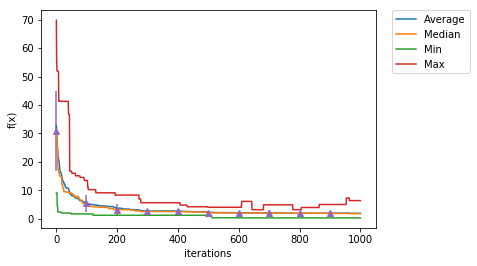

In [97]:
plotGraphs(total_history5)

In [98]:
print("Optimal founds:")
for x in optimal_found5:
    print(Rastrigin(np.array(x)))

Optimal founds:
1.265713399730565
3.2579582206011537
2.8697199203864585
2.5105200853294285
1.9733662525697753
1.729804550104948
3.3512606663759215
1.791681717670368
0.35613846172971364
0.5056711365985507
2.3785445737769066
1.1141211756961802
2.835691630457376
1.5130423584561044
2.2100229823810977
1.5537046020129637
2.4696095666321938
2.230331814465803
1.0069117007296882
1.894882439071555
0.4177801254651001
2.4792595718204105
1.9914851544913859
0.7074057277568713
1.2858681913448038
1.021450122509087
1.767278846118188
2.3217842992637365
1.7931887785965692
6.438444003000022


### 10-Dimensions

In [ ]:
optimal_found25 = []
total_history25 = []

for i in range(num_experiments):
    x = np.random.random(10) * 10.24 - 5.12
    f = Rastrigin
    optimum, history_loss = HillClimbing(x, f, (-5.12,5.12), num_iterations=10000)
    #total_history += np.array(history_loss)
    total_history25.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found25.append(optimum)

total_history25 = np.array(total_history25)
print(total_history25.shape)

In [ ]:
plotGraphs(total_history25)

In [ ]:
print("Optimal founds:")
for x in optimal_found25:
    print(Rastrigin(np.array(x)))

# Rosenbrock

In [109]:
def Rosenbrock(x):
    return 100 * (x[0]**2-x[1])**2 + (1-x[0])**2

def RosenbrockTF(x):
    return 100 * tf.pow(tf.pow(x[0]-tf.pow(x[1], 2), 2), 2) + tf.pow(1-x[0], 2) 

## Rosenbrock with Newton-Raphson

In [ ]:
sess = tf.Session()
optimal_found6 = []

total_history6 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 4.096 - 2.048))
        
    sess.run(tf.initialize_all_variables())

    f1 = RosenbrockTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 1000)
    #total_history += np.array(history_loss)
    total_history6.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found6.append(optimum)
    
total_history6 = np.array(total_history6)
print(total_history6.shape)
sess.close()

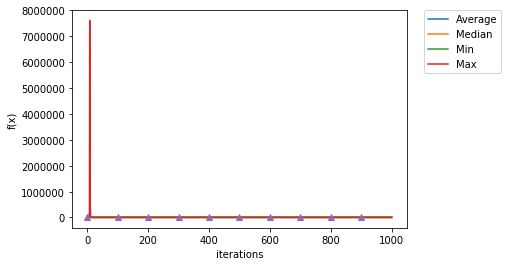

In [99]:
plotGraphs(total_history6)

In [100]:
print("Optimal founds:")
for x in optimal_found6:
    print(Rastrigin(np.array(x)))

Optimal founds:
4.734855651855469
4.734855651855469
2.0
2.0
4.734855651855469
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
4.734857559204102
2.0
2.0
2.0
2.0
2.0
2.0
2.0
4.734855651855469
2.0
2.0
2.0
4.734855651855469
2.0
2.0
2.0
2.0


## Rosenbrock with Gradient Descent

In [113]:
sess = tf.Session()
optimal_found7 = []

total_history7 = []


for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 4.096 - 2.048))
        
    sess.run(tf.initialize_all_variables())

    f1 = RosenbrockTF(x)
    optimum, history_loss = GradientDescent(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history7.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found7.append(optimum)
    
total_history7 = np.array(total_history7)
print(total_history7.shape)
sess.close()

(30, 1000)


/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 997 results
  r = func(a, **kwargs)
/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


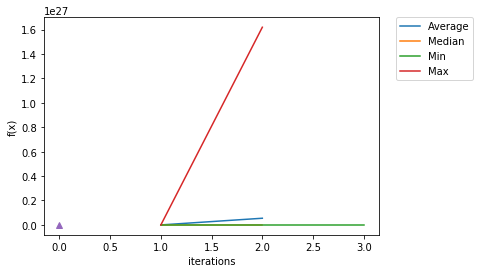

In [101]:
plotGraphs(total_history7)

In [102]:
print("Optimal founds:")
for x in optimal_found7:
    print(Rastrigin(np.array(x)))

Optimal founds:
nan
nan
nan
nan
nan
nan
nan
nan
nan
2.009357452392578
nan
nan
nan
nan
nan
nan
nan
nan
1.9951629638671875
nan
nan
nan
1.9952049255371094
nan
nan
nan
nan
1.9949836730957031
nan
nan


## Rosenbrock with Momentum

In [119]:
sess = tf.Session()
optimal_found8 = []

total_history8 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 4.096 - 2.048))
        
    sess.run(tf.initialize_all_variables())

    f1 = RosenbrockTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history8.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found8.append(optimum)
    
total_history8 = np.array(total_history8)
print(total_history8.shape)
sess.close()

(30, 1000)


/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 997 results
  r = func(a, **kwargs)
/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


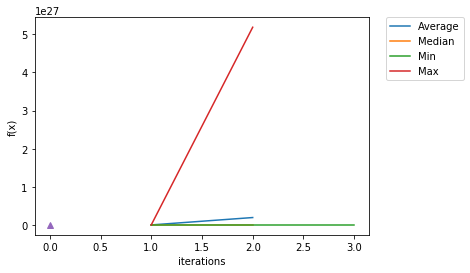

In [103]:
plotGraphs(total_history8)

In [104]:
print("Optimal founds:")
for x in optimal_found8:
    print(Rastrigin(np.array(x)))

Optimal founds:
nan
2.0056533813476562
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1.9962425231933594
nan
nan
nan
nan
nan
nan
nan
1.9961566925048828
nan
nan
nan
nan
nan
nan
nan
nan


## Rosenbrock with Hill-Climbing

In [127]:
optimal_found9 = []
total_history9 = []

for i in range(num_experiments):
    x = np.random.random(2) * 4.096 - 2.48
    f = Rosenbrock
    optimum, history_loss = HillClimbing(x, f, (-2.048,2.048), num_iterations=1000)
    #total_history += np.array(history_loss)
    total_history9.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found9.append(optimum)

total_history9 = np.array(total_history9)
print(total_history9.shape)

(30, 1000)


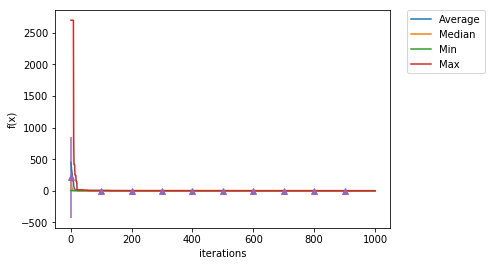

In [105]:
plotGraphs(total_history9)

In [106]:
print("Optimal founds:")
for x in optimal_found9:
    print(Rastrigin(np.array(x)))

Optimal founds:
4.491372484909581
10.373198904201226
7.604076646625071
12.83993555930499
4.225094615639513
7.170224548603599
7.506175610259344
6.115912754989402
10.359126257072287
11.236210315899747
5.184832296923025
6.310858539863085
2.113497312435456
17.80289178045721
3.0761722614671427
5.172384470529485
10.789007130591182
2.033289898988194
9.13005552423839
2.1411851704399076
13.478711548651566
18.81573740005579
2.0702508053199864
3.6903542266200233
2.0154053266405825
8.543392416472956
5.053106709149995
5.676895698030487
19.204962187373322
3.413050734711682


## Rosenbrock with Simulated Annealing

In [110]:
optimal_found10 = []
total_history10 = []

for i in range(num_experiments):
    x = np.random.random(2) * 4.096 - 2.048
    f = Rosenbrock
    optimum, history_loss = SimulatedAnnealing(x, f, (-2.048,2.048), t_max=1000)
    #total_history += np.array(history_loss)
    total_history10.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found10.append(optimum)

total_history10 = np.array(total_history10)
print(total_history10.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 1000)


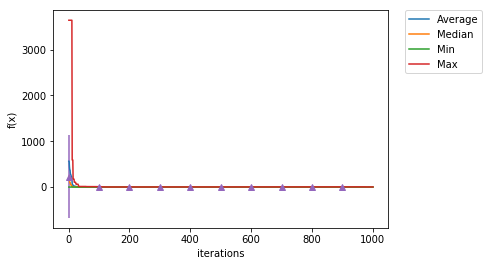

In [111]:
plotGraphs(total_history10)

In [112]:
print("Optimal founds:")
for x in optimal_found10:
    print(Rastrigin(np.array(x)))

Optimal founds:
35.6757528384107
26.358323801329675
7.439385677736841
24.880174034283165
27.266194513016192
13.024739407782004
35.58161838182288
31.10616418416251
31.07253380754886
27.98889713885988
33.280361070502785
31.52432950962038
30.14323319317323
22.624740581696784
35.35967025370131
4.065535451595796
25.41181021470134
24.038617357168135
26.31607295761773
4.688505780659703
5.227606919003005
8.866099179118866
26.952235882421324
10.276140658582072
2.101444916560908
24.17407385057639
29.58285828969898
28.97687934908145
17.57498384380165
26.699003435833454


# Schwefel

In [118]:
def Schwefel(x):
    d = len(x)
    return 418.9829 * d + np.sum(x * np.sin(np.sqrt(np.abs(x))))

def SchwefelTF(x):
    d = len(x)
    return 418.9829 * d + tf.reduce_sum(tf.multiply(tf.negative(x), tf.sin([tf.sqrt(abs(xi)) for xi in x])))

## Schwefel with Newton-Raphson

### 2-Dimensions

In [166]:
sess = tf.Session()
optimal_found11 = []

total_history11 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 1000)
    #total_history += np.array(history_loss)
    total_history11.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found11.append(optimum)
    
total_history11 = np.array(total_history11)
print(total_history11.shape)
sess.close()

(30, 1000)


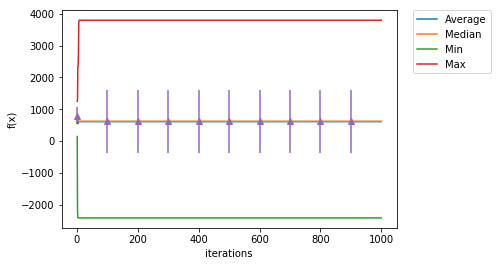

In [113]:
plotGraphs(total_history11)

In [114]:
print("Optimal founds:")
for x in optimal_found11:
    print(Rastrigin(np.array(x)))

Optimal founds:
892079.4375
268756.0625
177251.609375
181530.953125
83092.6328125
11452632.0
218761.15625
1755687.0
218761.1875
15624.3564453125
95857.28125
354429.6875
42218.78515625
268756.125
1369933.375
91577.984375
268756.0625
133087.53125
11614259.0
709.2341918945312
45862.390625
57133.91015625
177887.34375
354429.71875
133087.515625
3265434.5
268756.09375
95857.2890625
354429.6875
181530.984375


### 10-Dimensions

In [ ]:
sess = tf.Session()
optimal_found26 = []

total_history26 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 10000)
    #total_history += np.array(history_loss)
    total_history26.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found26.append(optimum)
    
total_history26 = np.array(total_history26)
print(total_history26.shape)
sess.close()

In [ ]:
plotGraphs(total_history26)

In [ ]:
print("Optimal founds:")
for x in optimal_found26:
    print(Rastrigin(np.array(x)))

## Schwefel with Gradient Descent

### 2-Dimensions

In [119]:
sess = tf.Session()
optimal_found12 = []

total_history12 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = GradientDescent(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history12.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found12.append(optimum)
    
total_history12 = np.array(total_history12)
print(total_history12.shape)
sess.close()

(30, 1000)


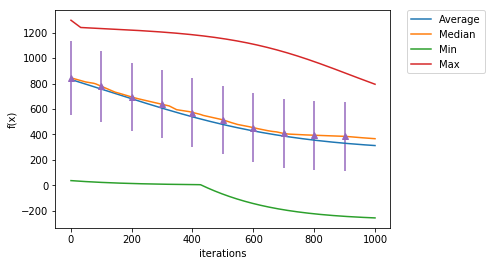

In [120]:
plotGraphs(total_history12)

In [121]:
print("Optimal founds:")
for x in optimal_found12:
    print(Rastrigin(np.array(x)))

Optimal founds:
98206.3359375
378480.0
477240.75
195098.59375
332024.59375
125450.84375
55071.0703125
172594.40625
43452.50390625
54859.9296875
352972.4375
606890.625
190321.78125
92396.375
179079.46875
361053.1875
180352.90625
130355.65625
179840.75
266757.9375
95695.9609375
62676.62109375
347574.625
465883.25
260962.5625
14803.8818359375
170119.875
259571.15625
107171.859375
84024.3359375


### 10-Dimensions

In [ ]:
sess = tf.Session()
optimal_found27 = []

total_history27 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 10000)
    #total_history += np.array(history_loss)
    total_history27.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found27.append(optimum)
    
total_history27 = np.array(total_history27)
print(total_history27.shape)
sess.close()

In [ ]:
plotGraphs(total_history27)

In [ ]:
print("Optimal founds:")
for x in optimal_found27:
    print(Rastrigin(np.array(x)))

## Schwefel with Momentum

In [174]:
sess = tf.Session()
optimal_found13 = []

total_history13 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history13.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found13.append(optimum)
    
total_history13 = np.array(total_history13)
print(total_history13.shape)
sess.close()

(30, 1000)


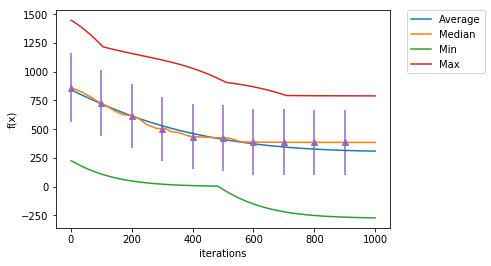

In [175]:
plotGraphs(total_history13)

## Schwefel with Hill-Climbing

In [176]:
optimal_found14 = []
total_history14 = []

for i in range(num_experiments):
    x = np.random.random(2) * 1024 - 512
    f = Schwefel
    optimum, history_loss = HillClimbing(x, f, (-512, 512), num_iterations=1000)
    #total_history += np.array(history_loss)
    total_history14.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found14.append(optimum)

total_history14 = np.array(total_history14)
print(total_history14.shape)

(30, 1000)


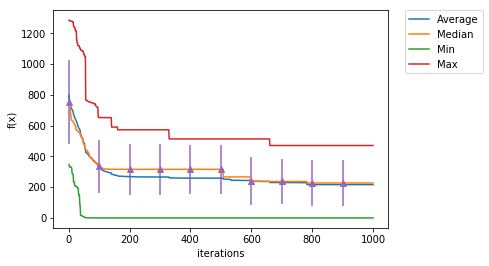

In [177]:
plotGraphs(total_history14)

## Schwefel with Simulated Annealing

In [182]:
optimal_found15 = []
total_history15 = []

for i in range(num_experiments):
    x = np.random.random(2) * 1024 - 512
    f = Schwefel
    optimum, history_loss = SimulatedAnnealing(x, f, (-512, 512), t_max=1000)
    #total_history += np.array(history_loss)
    total_history15.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found15.append(optimum)

total_history15 = np.array(total_history15)
print(total_history15.shape)

(30, 1000)


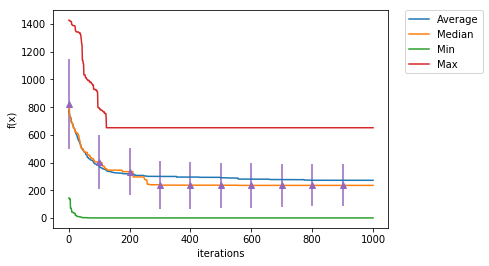

In [42]:
plotGraphs(total_history15)

# Griewank

In [44]:
def Griewank(x):
    d = len(x)
    return 1 + np.sum(x**2 / 4000) - np.prod(np.cos(x/np.sqrt(np.arange(1,d+1))))

def GriewankTF(x):
    d = len(x)
    return 1 + tf.reduce_sum([xi**2/4000 for xi in x]) - tf.reduce_prod(tf.cos([x[i]/(i+1) for i in range(d)]))

## Griewank with Newton-Raphson

In [189]:
sess = tf.Session()
optimal_found16 = []

total_history16 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 1000)
    #total_history += np.array(history_loss)
    total_history16.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found16.append(optimum)
    
total_history16 = np.array(total_history16)
print(total_history16.shape)
sess.close()

(30, 1000)


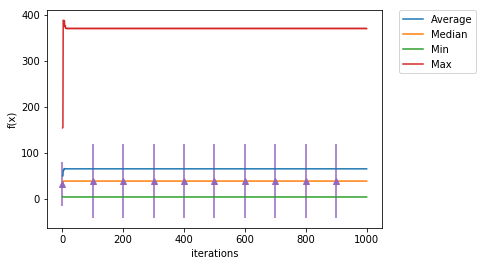

In [190]:
plotGraphs(total_history16)

## Griewank with Gradient Descent

In [49]:
sess = tf.Session()
optimal_found17 = []

total_history17 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = GradientDescent(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history17.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found17.append(optimum)
    
total_history17 = np.array(total_history17)
print(total_history17.shape)
sess.close()

(30, 1000)


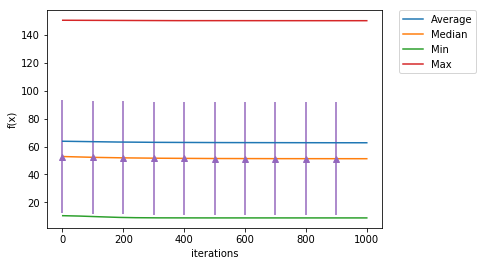

In [50]:
plotGraphs(total_history17)

## Griewank with Momentum

In [51]:
sess = tf.Session()
optimal_found18 = []

total_history18 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history18.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found18.append(optimum)
    
total_history18 = np.array(total_history18)
print(total_history18.shape)
sess.close()

(30, 1000)


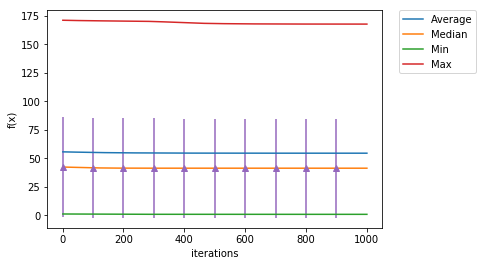

In [52]:
plotGraphs(total_history18)

## Griewank with Hill Climbing

In [53]:
optimal_found19 = []
total_history19 = []

for i in range(num_experiments):
    x = np.random.random(2) * 1200 - 600
    f = Griewank
    optimum, history_loss = HillClimbing(x, f, (-600, 600), num_iterations=1000)
    #total_history += np.array(history_loss)
    total_history19.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found19.append(optimum)

total_history19 = np.array(total_history19)
print(total_history19.shape)

(30, 1000)


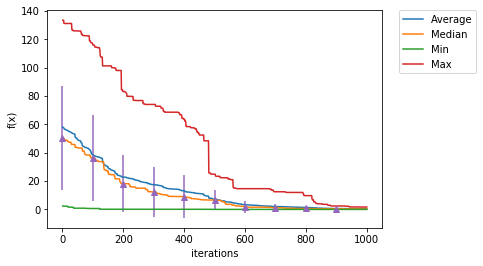

In [54]:
plotGraphs(total_history19)

## Griewank with Simulated Annealing

In [55]:
optimal_found20 = []
total_history20 = []

for i in range(num_experiments):
    x = np.random.random(2) * 1200 - 600
    f = Griewank
    optimum, history_loss = SimulatedAnnealing(x, f, (-600, 600), t_max=1000)
    #total_history += np.array(history_loss)
    total_history20.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found20.append(optimum)

total_history20 = np.array(total_history20)
print(total_history20.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 1000)


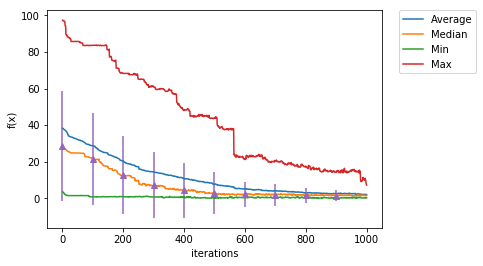

In [56]:
plotGraphs(total_history20)

# Saving the models

In [122]:
total_histories = [total_history, total_history2, total_history3, total_history4, total_history5, total_history6, total_history7, total_history8, total_history9, total_history10, total_history11, total_history12, total_history13, total_history14, total_history15, total_history16, total_history17, total_history18, total_history19, total_history20, total_history21]
optimal_founds = [optimal_found1, optimal_found2, optimal_found3, optimal_found4, optimal_found5, optimal_found6, optimal_found7, optimal_found8, optimal_found9, optimal_found10, optimal_found11, optimal_found12, optimal_found13, optimal_found14, optimal_found15, optimal_found16, optimal_found17, optimal_found18, optimal_found19, optimal_found20, optimal_found21]

pickle.dump(total_histories, open("total_histories.pickle", 'wb'))
pickle.dump(optimal_founds, open("optimal_founds.pickle", 'wb'))

In [34]:
total_histories = pickle.load(open("total_histories.pickle", 'rb'))
optimal_founds = pickle.load(open("optimal_founds.pickle", 'rb'))

In [41]:
total_history = total_histories[0]
total_history2 = total_histories[1]
total_history3 = total_histories[2]
total_history4 = total_histories[3]
total_history5 = total_histories[4]
total_history6 = total_histories[5]
total_history7 = total_histories[6]
total_history8 = total_histories[7]
total_history9 = total_histories[8]
total_history10 = total_histories[9]
total_history11 = total_histories[10]
total_history12 = total_histories[11]
total_history13 = total_histories[12]
total_history14 = total_histories[13]
total_history15 = total_histories[14]
total_history16 = total_histories[15]

optimal_found1 = optimal_found[0]
optimal_found2 = optimal_found[1]
optimal_found3 = optimal_found[2]
optimal_found4 = optimal_found[3]
optimal_found5 = optimal_found[4]
optimal_found6 = optimal_found[5]
optimal_found7 = optimal_found[6]
optimal_found8 = optimal_found[7]
optimal_found9 = optimal_found[8]
optimal_found10 = optimal_found[9]
optimal_found11 = optimal_found[10]
optimal_found12 = optimal_found[11]
optimal_found13 = optimal_found[12]
optimal_found14 = optimal_found[13]
optimal_found15 = optimal_found[14]
optimal_found16 = optimal_found[15]